In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

from sklearn.neighbors import KernelDensity

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers
import tensorflow as tf
tfk = tf.keras
tfkl = tfk.layers

import pymc3 as pm

<a name="cell-MCint-sampling-copulas"></a>

## 4.3.1 Copulas: Conditional Distributions via Differentiation ([Return to TOC](#cell-TOC-numint))

---

A *copula* defines (acording to Sklar's theorem) a *joint (e.g., bivariate)* distribution of two random variables $X$ and $Y$ with *marginal* (e.g., univariate) CDFs $F_X$ and $F_Y$ by (effectively essentially) specifying the dependency structure between these two marginal distributions through their joint CDF function 

$$F_{(X,Y)}\big((x,y)\big) = \Pr(X\leq x, Y \leq y) \require{cancel}$$

while maintaining compatibility with the originally specified marginal CDFs $F_X$ and $F_Y$. That is, a *copula* defines the details of how the joint CDF actually achieves each of the marginal CDFs.  

- E.g., $F(x) = \Pr(X\leq x) \not = \Pr(X\leq x | Y= y)$ since the latter concerns the information contained in the *joint* distribution while the former does not consider the updated information gained by knowing $Y = y$; but, these two probability specifications can still be compatible nonetheless.

*Copulas* are not actually defined as $F_{(X,Y)}\big((x,y)\big) = \Pr(X\leq x, Y \leq y)$ though; but, are instead (equivalently) defined through the random variables 
- $U_X=F_X(X)$ and $U_Y=F_Y(Y)$
  - (which are indeed uniform random variables as the notation suggests)

as (here shown in several equivalent notations) 

$$\begin{align*}C(F_X, F_Y) = C_{F_X, F_Y}(u_x,u_y) = C_{F_X(X), F_Y(Y)}(u_x,u_y) = & {} \\
 \Pr(F_X(X)\leq u_x, F_Y(Y)\leq u_y) = \Pr(U_x\leq u_x, U_Y\leq u_y) = F_{(U_x,U_y)}\big((u_x,u_y)\big)\end{align*}$$

which specifies that
1. the arguments of the *copula*, here $u_x$ and $u_y$, are on the unit interval
2. the *copula* is defined in terms of and thus depends on the marginal CDFs
3. the *joint* distribution $(X,Y) \sim F_{(X,Y)}\big((x,y)\big)$ is defined by instead defining the *copula*

   $$\begin{align*}
   F_{(X,Y)}\big((x,y)\big) = \Pr(X \leq x, Y \leq y) = {} & \Pr(F_X(X)\leq F_X(x), F_Y(Y)\leq F_Y(y))\\ 
   \equiv {} & \Pr(F_X(X)\leq u_x, F_Y(Y)\leq u_y)\\
   = {} &  C_{F_X, F_Y}(u_x,u_y) = C(F_X, F_Y)\end{align*}$$

Thus, returning to and leveraging to the *inverse CDF sampling* approach

- let $U_X \sim U(0,1)$ and $X = F_X^{-1}(U_X)$ 
- let $U_{F_Y|F_X} \sim U(0,1)$ and $Y = F_Y^{-1}\Bigg(\overbrace{\left[ \frac{\partial}{\partial F_X} C(F_X, F_Y)\right]^{-1}\!\!\left(U_{F_Y|F_X} \right)}^{F_Y|F_X \text{: a value for $F_Y(Y)$ given $F_X(X)$ }} \Bigg)$

so that $Y \sim F_{Y|X}(y|x)$ and $(X,Y) \sim F_{(X,Y)}\big((x,y)\big)$ which can be seen (as demonstrated [here](https://stats.stackexchange.com/questions/90283/how-to-find-conditional-probability-pxxy-y-using-copulas)) from 

$$
\begin{align*}
Y \sim F_{Y|X}(y|x) = {} & \Pr(Y\leq y|X=x) \\
= {} & \overbrace{\frac{\Pr(Y\leq y, X=x)}{f_X(x)} = \frac{\frac{\partial}{\partial x} \Pr(Y\leq y, X\leq x)}{f_X(x)}}^{\text{this is the familiar result that the derivative of CDF is a PDF}}\\
= {} & \frac{\frac{\partial}{\partial x} \Pr(F_Y(Y)\leq F_Y(y), F_X(X)\leq F_X(x))}{f_X(x)}\\
= {} & \frac{\frac{\partial}{\partial u_x}\cancel{\frac{\partial u_x}{\partial x}}\Pr(U_Y\leq u_y, U_X\leq u_x)  }{\cancel{f_X(x)}} = \frac{\partial}{\partial F_X} C(F_X, F_Y)\\
\end{align*}
$$

or seen from the other direction (e.g., as demonstrated [here](https://stats.stackexchange.com/questions/191042/partial-derivative-of-joint-distribution-function-interpretation)) from

$$
\begin{align*}
\frac{\partial}{\partial F_X} C(F_X, F_Y) = {} & 
\frac{\partial}{\partial \big\{F_X(x)\big\}} C_{F_X(X), F_Y(Y)}(u_x,u_y) =\\
\frac{\partial}{\partial u_x} F_{(U_X, U_Y)}\big((u_x,u_y)\big)
  = {} & \frac{\partial}{\partial u_x} \int_{-\infty}^{u_x} \int_{-\infty}^{u_y} f_{(U_X, U_Y)}\big((u_1,u_2)\big) du_2du_1\\
   = {} &  \int_{-\infty}^{u_y} f_{(U_X, U_Y)}\big((u_x,u_2)\big) du_2 
   = \int_{-\infty}^{u_y} \frac{f_{(U_X, U_Y)}\big((u_x,u_2)\big) }{\underbrace{f_{U_X}(u_x)}_{\text{$1$ for unifrom $U_X$}}} du_2\\
   = {} &  \int_{-\infty}^{u_y} f_{U_Y|U_X}(u_2|u_x) du_2 
   = F_{U_X|U_Y}(u_y|u_x) = F_{Y|X}(y|x)
\end{align*}
$$

because the auxiliary random variables, e.g., $U_Y|U_X = F_Y(Y)|F_X(X)$,

1. define (i.e., are equivalent to) the probabilities of the random variables of interest, e.g., $Y|X$, and
2. the random variables of interest can be extracted from the auxiliary random variables (which are following exactly the probabilities of interest). 

One key point to note is the fact that $f_{U_X}(u_x)=1$ for uniform $U_X = F_X(X)$ can now be seen to be the motivation for employing the overhead of a *copula* in the first place rather than just directly defining the *joint* CDF $F_{(X,Y)}\big((X,Y)\big)$ since this is what allows the derivation of *conditional* distributions.  

- I.e., *conditional* distributions of *copulas* are partial derivatives of the *copula* which is not something that's true for any other family of distributions. 

Another pragmatic, perhaps simpler way to view *copulas* is just as a specific usage of transformation of variables; namely, the transformation of the marginal distributions (of a joint distribution with a specific correlation structure) into a collection of alternative (desired) pairwise (marginal) distributions whose dependency structure is still defined by the correlation structure of the intial underlying joint distribution.  
- I.e., the marginal distributions of a joint distribuition may each be warped; but, the correlation structure between the warped variables may still be defined in terms of the original joint distribuition by mapping the values of the warped variables back to the original marginals and then judging the dependency there.
- I.e., sample from an underlying joint distribution with a given dependency structure, and then simply warp each marginal distribution into the desired alternative distribution desired for that margin.

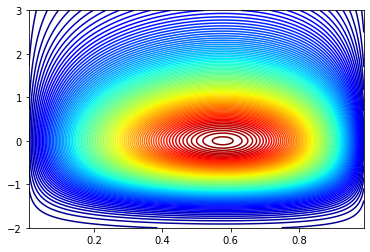

In [ ]:
# https://www.tensorflow.org/probability/examples/Gaussian_Copula

a,b,gloc,gscale = 2.0, 2.0, 0., 1.
x = tfd.Kumaraswamy(a, b)
y = tfd.Gumbel(loc=gloc, scale=gscale)

# assuming independence
x_axis_interval = np.linspace(0.01, 0.99, num=200, dtype=np.float32)
y_axis_interval = np.linspace(-2., 3., num=200, dtype=np.float32)
x_grid, y_grid = np.meshgrid(x_axis_interval, y_axis_interval)

pdf = x.prob(x_grid) * y.prob(y_grid)
plt.contour(x_grid, y_grid, pdf, 100, cmap=plt.cm.jet);

In [ ]:
# A `bijector` is an object defining the forward and backward transformations
# as well as they Jacobian, of a specific invertible transformation

class GaussianCopulaTriL(tfd.TransformedDistribution):
  def __init__(self, loc, scale_tril):
    super(GaussianCopulaTriL, self).__init__(
      # `scale_tril=scale_tril` is a lower triangular Cholesky factor matrix
      distribution=tfd.MultivariateNormalTriL(loc=loc, scale_tril=scale_tril),
      # The base distribuition has defined joint CDF calculations 
      # The Normal margins are transformed to Uniform variables here
      bijector=tfb.NormalCDF(),
      # And to get the joint CDF calculations for the Unifrom variables
      # they are just transformed back to the base distribution
      # and the joint CDF calculation is done there 
      validate_args=False, name="GaussianCopulaTriLUniform")

class WarpedGaussianCopula(tfd.TransformedDistribution):
  def __init__(self, loc, scale_tril, marginal_bijectors, block_sizes=None):
    # `block_sizes` the number of dimensions contributed by `marginal_bijectors`
    # so `len(marginal_bijectors)` must equal `len(block_sizes)`
    super(WarpedGaussianCopula, self).__init__(
      distribution=GaussianCopulaTriL(loc=loc, scale_tril=scale_tril),
      # The base distribution is a `GaussianCopulaTriL` which is defined to have
      # Uniform marginal distributions; thus, `marginal_bijectors` need only
      # transform these Uniform variables to the desired arbitrary distribution
      bijector=tfb.Blockwise(bijectors=marginal_bijectors, 
                             block_sizes=block_sizes),
      validate_args=False, name="GaussianCopula")

# The lower triangular Cholesky factor matrix L
# [1             0      ]
# [\rho \sqrt(1-rho*rho)]
# defines a covariance matrix with variances 1 and covariance \rho
# which means the correlation is also \rho, i.e., LL^T 
# [  1 \rho]
# [\rho  1 ] e.g., 
# L = np.array([[1,0],[.8, np.sqrt(1-.8**2)]])
# L.dot(L.T)
def create_gaussian_copula(correlation):
  # Use Gaussian Copula to add dependence.
  return WarpedGaussianCopula(
      loc=[0.,  0.],
      scale_tril=[[1., 0.], [correlation, tf.sqrt(1. - correlation ** 2)]],
      # These encode the marginals we want: X_0 Kumaraswamy, X_1 Gumbel 
      marginal_bijectors=[
      tfb.Invert(tfb.KumaraswamyCDF(a, b)), 
      tfb.Invert(tfb.GumbelCDF(loc=0., scale=1.))])
      # `tfb.KumaraswamyCDF` and `tfb.GumbelCDF` map into [0,1]
      # tfb.Invert is so they map from [0,1] since `WarpedGaussianCopula` has
      # `distribution=GaussianCopulaTriL` which has Uniform marginals

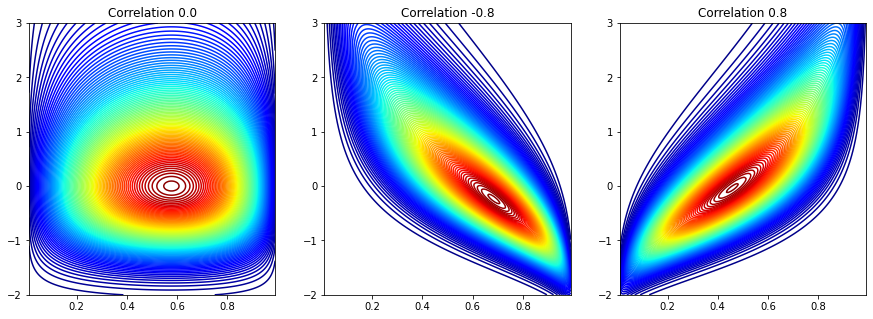

In [ ]:
# Arbitrary marginal distributions x, each mapped to Uniform distributions u,
# each mapped to a Normal distribution with Multivariate Normal Covariance n.
# Calculations of the joint distribution of the arbitrary marginal distributions
# i.e., `copula.prob(x)` are thus deferred to the "MNV.prob(x -> u -> n)"
# where the Jacobians are retained by the `bijection` objects so the correction
# factor required for the change of variables can be applied at each transform

coordinates = np.concatenate(
    [x_grid[..., np.newaxis], y_grid[..., np.newaxis]], -1)
correlations = [0., -0.8, 0.8]
copulas, probs = [], []
for correlation in correlations:
  copula = create_gaussian_copula(correlation)
  copulas.append(copula)
  probs.append(copula.prob(coordinates))

fig, ax = plt.subplots(1,3, figsize=(15,5))
for i, (correlation, copula_prob) in enumerate(zip(correlations, probs)):
  ax[i].contour(x_grid, y_grid, copula_prob, 100, cmap=plt.cm.jet)
  ax[i].set_title('Correlation {}'.format(correlation))

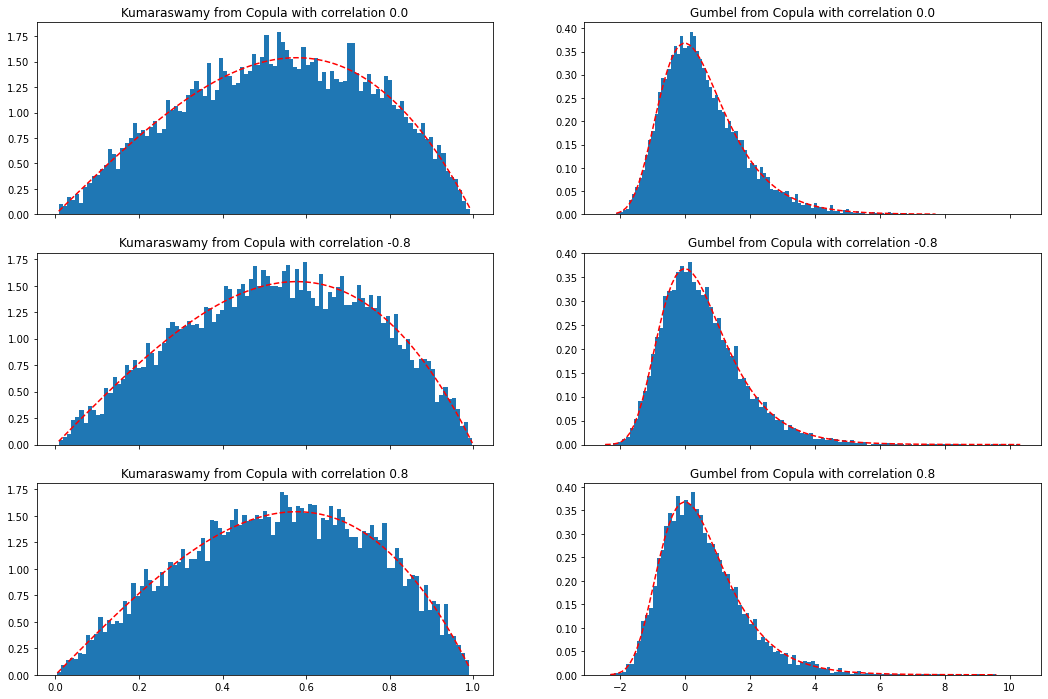

In [ ]:
# And indeed the marginal distributions are as advertised

def kumaraswamy_pdf(x):
    return tfd.Kumaraswamy(a, b).prob(np.float32(x))

def gumbel_pdf(x):
    return tfd.Gumbel(gloc, gscale).prob(np.float32(x))

copula_samples = []
for copula in copulas:
  copula_samples.append(copula.sample(10000))
plot_rows, plot_cols = len(correlations),2 
fig, axes = plt.subplots(plot_rows, plot_cols, sharex='col', figsize=(18,12))

# Let's marginalize out on each, and plot the samples.
for i, (correlation, copula_sample) in enumerate(zip(correlations, copula_samples)):
  k = copula_sample[..., 0].numpy()
  g = copula_sample[..., 1].numpy()
  _, bins, _ = axes[i, 0].hist(k, bins=100, density=True)
  axes[i, 0].plot(bins, kumaraswamy_pdf(bins), 'r--')
  axes[i, 0].set_title('Kumaraswamy from Copula with correlation {}'.format(correlation))
  _, bins, _ = axes[i, 1].hist(g, bins=100, density=True)
  axes[i, 1].plot(bins, gumbel_pdf(bins), 'r--')
  axes[i, 1].set_title('Gumbel from Copula with correlation {}'.format(correlation))

*This example is based on this [TensorFlow Probability (TFP) tutorial](https://www.tensorflow.org/probability/examples/Gaussian_Copula)*.